# Structure projections on an Image

Once particle locations and orientations have been identified, we can go back and plot the projections of the template structure back onto the original micrograph.
This example goes through and generates this plot on a set of already template matched data.

In [1]:
import os

import matplotlib.pyplot as plt
import mrcfile
import numpy as np
import pandas as pd
import torch
from scipy.signal import wiener

from leopard_em.utils.fourier_slice import get_real_space_projections_from_volume

plt.rcParams["figure.dpi"] = 120

### Downloading Example Data

Run the following code cell to download the results into the current directory of the notebook.
Otherwise, place the downloaded data in the same directory as the notebook or adjust the paths in the following cell(s).

In [2]:
!zenodo_get https://doi.org/10.5281/zenodo.15426374 \
--glob "60S_map_px0.936_bscale0.5.mrc" \
--glob "xenon_216_000_0.0_DWS.mrc" \
--glob "xenon_216_000_0.0_DWS_results.csv"

Title: 2DTM inputs and program results from the Leopard-EM Python package
Keywords: 
Publication date: 2025-05-15
DOI: 10.5281/zenodo.15426374
Total size: 604.1 MB

File: 60S_map_px0.936_bscale0.5.mrc (536.9 MB)
Link: https://zenodo.org/api/records/15426374/files/60S_map_px0.936_bscale0.5.mrc/content
60S_map_px0.936_bscale0.5.mrc is already downloaded correctly.

File: xenon_216_000_0.0_DWS_results.csv (118.6 kB)
Link: https://zenodo.org/api/records/15426374/files/xenon_216_000_0.0_DWS_results.csv/content
100% [........................................................] 118621 / 118621
Checksum is correct for xenon_216_000_0.0_DWS_results.csv. (7aae48e3ce68f41230b3e778089ed2a7)

File: xenon_216_000_0.0_DWS.mrc (67.1 MB)
Link: https://zenodo.org/api/records/15426374/files/xenon_216_000_0.0_DWS.mrc/content
100% [....................................................] 67109888 / 67109888
Checksum is correct for xenon_216_000_0.0_DWS.mrc. (a38451fabc9a2bdbdac3b83e39d5df6a)

All specified files

In [3]:
import requests


def download_zenodo_file(url: str) -> str:
    """Downloads a zenodo file from the given URL. Returns the output filename."""
    output_filename = url.split("/")[-1]

    # Check if the file already exists
    if os.path.exists(output_filename):
        print(f"File {output_filename} already exists. Skipping download.")
        return output_filename

    response = requests.get(url, stream=True)
    response.raise_for_status()  # Check for request errors

    with open(output_filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    return output_filename


# NOTE: This may take a few seconds to few minutes, depending on internet connection
# fmt: off
file_urls = [
    "https://zenodo.org/records/15426374/files/60S_map_px0.936_bscale0.5.mrc",
    "https://zenodo.org/records/15426374/files/xenon_216_000_0.0_DWS.mrc",
    "https://zenodo.org/records/15426374/files/xenon_216_000_0.0_DWS_results.csv",
]
# fmt: on

for url in file_urls:
    filename = download_zenodo_file(url)
    print(f"Downloaded {filename}")

File 60S_map_px0.936_bscale0.5.mrc already exists. Skipping download.
Downloaded 60S_map_px0.936_bscale0.5.mrc
File xenon_216_000_0.0_DWS.mrc already exists. Skipping download.
Downloaded xenon_216_000_0.0_DWS.mrc
File xenon_216_000_0.0_DWS_results.csv already exists. Skipping download.
Downloaded xenon_216_000_0.0_DWS_results.csv


## Loading in micrograph

Read in the micrograph mrc file into a numpy array visualize it using `matplotlib`.

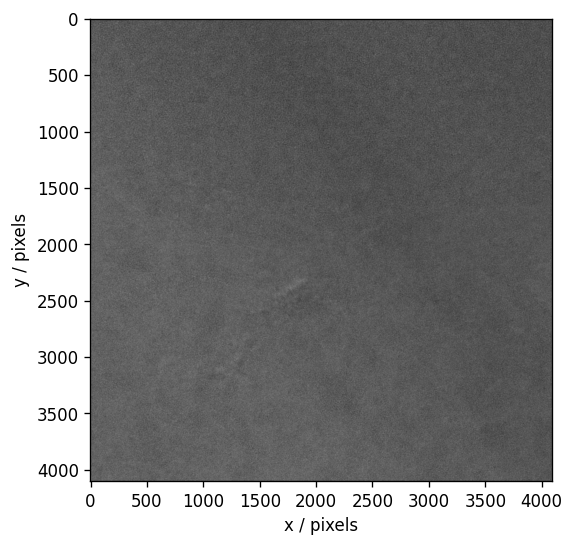

In [4]:
micrograph_path = "xenon_216_000_0.0_DWS.mrc"
micrograph = mrcfile.open(micrograph_path, mode="r").data.copy()

# Show the micrograph
plt.figure(figsize=(5, 5))
plt.imshow(micrograph, cmap="gray")
plt.xlabel("x / pixels")
plt.ylabel("y / pixels")
plt.show()

## Loading in picked particle results to DataFrame

We downloaded the identified particles csv from the `match_template` program which contain the location and orientation of each particle.
These data will be used to generate and plot the structure re-projections later.

In [5]:
results_csv_path = "xenon_216_000_0.0_DWS_results.csv"
df = pd.read_csv(results_csv_path)
df

,Unnamed: 0,particle_index,mip,scaled_mip,correlation_mean,correlation_variance,total_correlations,pos_x,pos_y,pos_x_img,...,micrograph_path,template_path,mip_path,scaled_mip_path,psi_path,theta_path,phi_path,defocus_path,correlation_average_path,correlation_variance_path
0,0,0,11.810101,12.104484,0.025537,0.973570,20598240,3470,3336,3726,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relative_defocus.mrc,xenon_216_000_0_output_correlation_average.mrc,xenon_216_000_0_output_correlation_variance.mrc
1,1,1,11.348068,11.758850,0.130799,0.953943,20598240,3322,1945,3578,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relative_defocus.mrc,xenon_216_000_0_output_correlation_average.mrc,xenon_216_000_0_output_correlation_variance.mrc
2,2,2,11.823074,11.681293,0.062959,1.006748,20598240,1842,3353,2098,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relative_defocus.mrc,xenon_216_000_0_output_correlation_average.mrc,xenon_216_000_0_output_correlation_variance.mrc
3,3,3,11.246000,11.189375,-0.028836,1.007638,20598240,133,3452,389,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relative_defocus.mrc,xenon_216_000_0_output_correlation_average.mrc,xenon_216_000_0_output_correlation_variance.mrc
4,4,4,11.394345,11.041210,-0.032740,1.034949,20598240,1811,3249,2067,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relative_defocus.mrc,xenon_216_000_0_output_correlation_average.mrc,xenon_216_000_0_output_correlation_variance.mrc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,193,193,7.664472,7.848475,0.042711,0.971114,20598240,2254,1733,2510,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relative_defocus.mrc,xenon_216_000_0_output_correlation_average.mrc,xenon_216_000_0_output_correlation_variance.mrc
194,194,194,7.992585,7.818872,0.133709,1.005116,20598240,1376,2300,1632,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relative_defocus.mrc,xenon_216_000_0_output_correlation_average.mrc,xenon_216_000_0_output_correlation_variance.mrc
195,195,195,7.570004,7.792142,0.016312,0.969399,20598240,1945,1819,2201,...,xenon_216_000_0.0_DWS.mrc,60S_map_px0.936_bscale0.5.mrc,xenon_216_000_0_output_mip.mrc,xenon_216_000_0_output_scaled_mip.mrc,xenon_216_000_0_output_orientation_psi.mrc,xenon_216_000_0_output_orientation_theta.mrc,xenon_216_000_0_output_orientation_phi.mrc,xenon_216_000_0_output_relativ

### First scatter plot

Just for quick visualization purposes, we generate a quick scatter plot of the identified particle positions on top of the micrograph.

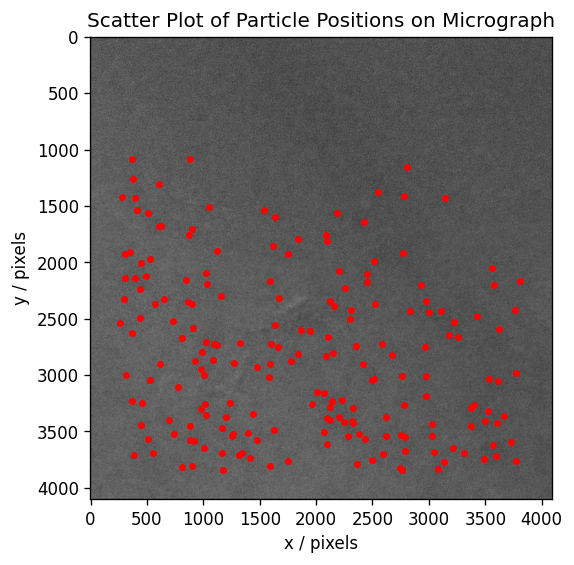

In [6]:
# Scatter plot of particle positions on top of the micrograph
plt.figure(figsize=(5, 5))


# Scatter plot of particle positions
plt.imshow(micrograph, cmap="gray")
plt.scatter(
    df["pos_x_img"],
    df["pos_y_img"],
    s=10,
    color="red",
)

# Set labels
plt.xlabel("x / pixels")
plt.ylabel("y / pixels")
plt.title("Scatter Plot of Particle Positions on Micrograph")
plt.show()

## Projections from simulated volume

To generate projections of a structure, we first need a simulated structure.
Leopard-EM includes a nice helper function to generate projections from a simulated volume from some set of orientations (angles in ZYZ Euler format).

In [7]:
template_volume_path = "60S_map_px0.936_bscale0.5.mrc"
template_volume = mrcfile.open(template_volume_path, mode="r").data.copy()
template_volume = torch.from_numpy(template_volume)
template_volume.shape

torch.Size([512, 512, 512])

In [8]:
# Generating the projections
projections = get_real_space_projections_from_volume(
    volume=template_volume,
    phi=torch.from_numpy(df["phi"].values).float(),
    theta=torch.from_numpy(df["theta"].values).float(),
    psi=torch.from_numpy(df["psi"].values).float(),
    degrees=True,
)
projections.shape

torch.Size([198, 512, 512])

### Some light pre-processing

Plot will have spatial units of Angstroms (not pixels), and Wiener filter can optionally be applied to the micrograph.

In [9]:
pixel_size = df.iloc[0]["pixel_size"].item()  # Angstroms / pixel
print(f"Pixel size (Å): {pixel_size}")

# Optionally apply a Wiener filter to image (params here are arbitrary)
apply_wiener = True
img = wiener(micrograph, mysize=20) if not apply_wiener else micrograph.copy()
print(f"Wiener filter applied: {apply_wiener}")

Pixel size (Å): 0.936
Wiener filter applied: True


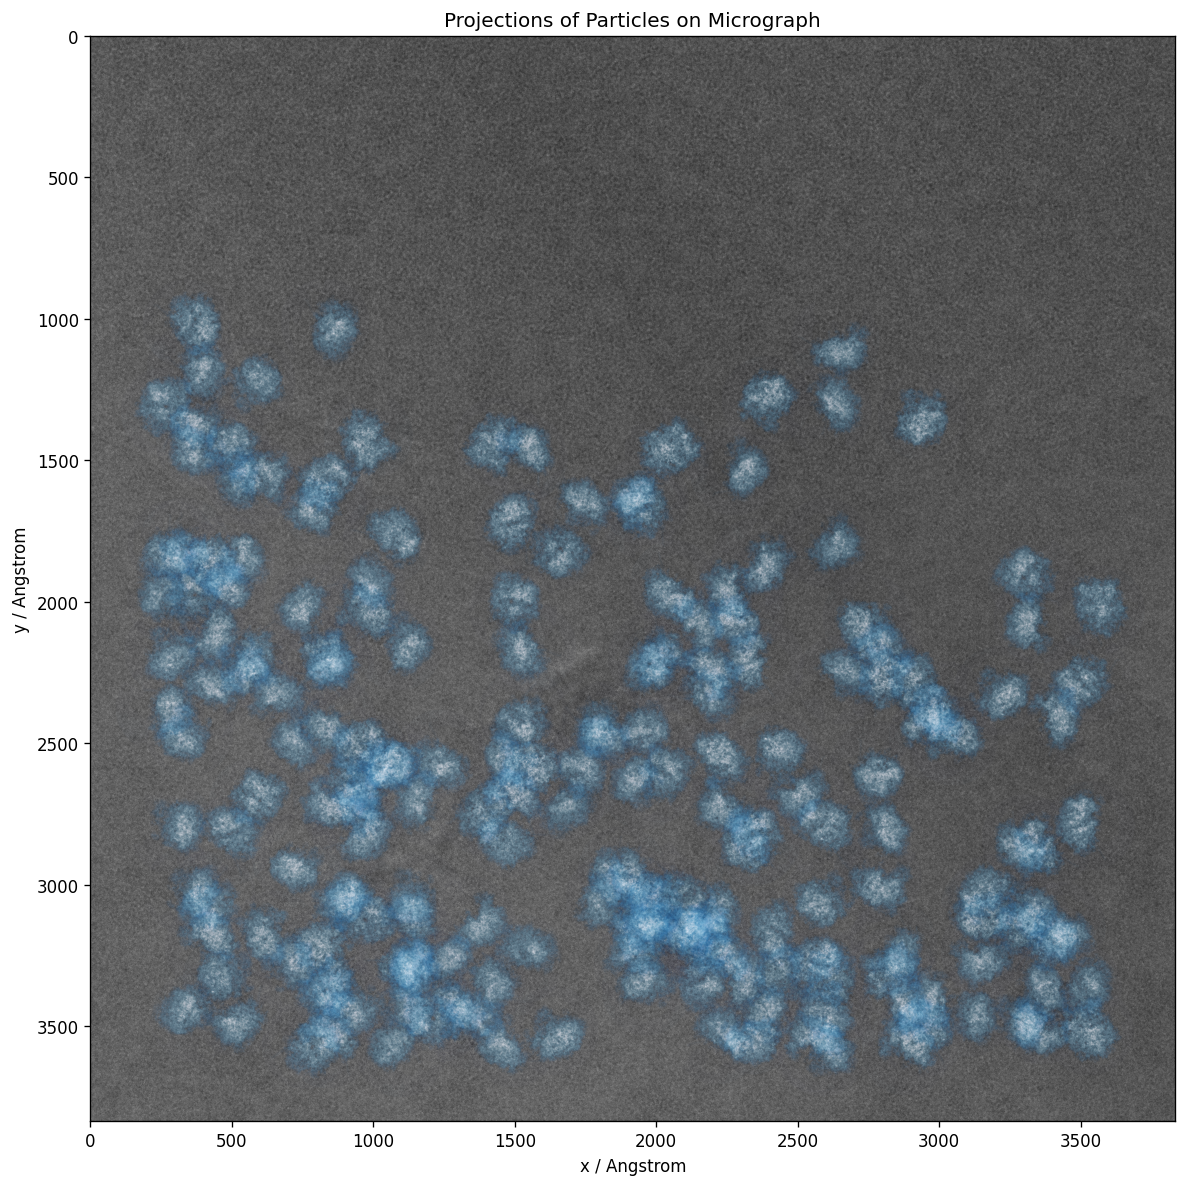

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(
    img,
    cmap="gray",
    extent=(0, img.shape[1] * pixel_size, img.shape[0] * pixel_size, 0),
)

# Iterate over each of the particle projections
for i, projection in enumerate(projections):
    projection = projection.numpy()

    # Get the position of the particle
    dx = df["pos_x_img_angstrom"].iloc[i]
    dy = df["pos_y_img_angstrom"].iloc[i]
    extent = [
        dx - (projection.shape[1] // 2 * pixel_size),
        dx + (projection.shape[1] // 2 * pixel_size),
        dy - (projection.shape[0] // 2 * pixel_size),
        dy + (projection.shape[0] // 2 * pixel_size),
    ]

    # Apply a circular mask to the projection
    mask = np.zeros_like(projection)
    h, w = mask.shape
    y, x = np.ogrid[:h, :w]
    r = np.sqrt((x - w // 2) ** 2 + (y - h // 2) ** 2)
    mask_area = r < 0.33 * min(h, w)
    mask[mask_area] = 1

    # Do normalization and coloring for projections
    projection = projection - projection.min()
    projection = projection / projection.max()
    normed_projection = 1 - projection
    projection = plt.cm.Blues(projection)
    projection[..., 3] = normed_projection * 0.8  # set alpha channel

    # Overlay the projection on the micrograph
    ax.imshow(
        projection * mask[..., None],
        extent=extent,
    )

# Manually setting the limits, otherwise the extent of the last projection is used
ax.set_xlim(0, img.shape[1] * pixel_size)
ax.set_ylim(0, img.shape[0] * pixel_size)
ax.invert_yaxis()

plt.xlabel("x / Angstrom")
plt.ylabel("y / Angstrom")
plt.title("Projections of Particles on Micrograph")

plt.tight_layout()
plt.show()